<a href="https://colab.research.google.com/github/tornikeo/lut-gpgpu-course/blob/main/gpgpu_e2_tornikeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student: Tornike Onoprishvili   
Exercise 2. Reduction patterns in CUDA.

In [1]:
from math import ceil as roof

import numpy as np
import cupy as cp
from cupy import cuda

assert cuda.is_available()

## Task 1:

Implement vector differentiation similar to numpy diff function using shared memory.

In [2]:
# First we do the lazy kernel design
cp.random.seed(42)
size = int(1e6)

inp_cu = cp.random.rand(size).astype('float32')
out_cu = cp.empty_like(inp_cu)
out_cu[-1] = 0

kernel_v1 = cp.RawKernel(
    r"""
    extern "C" __global__
    void kernel(float* inp, float* out, int len_inp) {
        int tx = threadIdx.x;
        int gx = tx + blockIdx.x * blockDim.x;
        if (gx < len_inp - 1) {
            out[gx] = inp[gx + 1] - inp[gx];
        }
    }
    """,'kernel'
)

THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp_cu) / (THREADS_PER_BLOCK[0] - 1)), 1, 1)

kernel_v1(
    BLOCKS_PER_GRID, THREADS_PER_BLOCK,
    (inp_cu, out_cu, cp.int32(len(inp_cu))),
)

y_true = cp.diff(inp_cu)
y_pred = cp.asnumpy(out_cu[:-1])

print(y_true)
print(y_pred)

cp.allclose(y_true, y_pred)

[ 0.05342758 -0.18849584  0.01305223 ...  0.8025053  -0.6967245
 -0.06736805]
[ 0.05342758 -0.18849584  0.01305223 ...  0.8025053  -0.6967245
 -0.06736805]


array(True)

In [3]:
# Better kernel with shared mem

cp.random.seed(42)
size = int(1e6)

inp_cu = cp.random.rand(size).astype('float32')
out_cu = cp.empty_like(inp_cu)
out_cu[-1] = 0

        
# @cuda.jit
# def kernel_v2(inp, out):
#     tx = cuda.threadIdx.x
#     bx = cuda.blockIdx.x
    
#     gx = cuda.grid(1)
#     sh = cuda.shared.array(THREADS_PER_BLOCK[0], numba.types.float32)

#     if gx - bx < len(inp):
#         sh[tx] = inp[gx - bx]
    
#     cuda.syncthreads()
    
#     if gx - bx < len(inp) and tx + 1 < len(sh):
#         out[gx - bx] = sh[tx + 1] - sh[tx]

kernel_v2 = cp.RawKernel(
    r"""
    extern "C" __global__
    void kernel(float* inp, float* out, int len_inp, int len_sh) {
        int tx = threadIdx.x;
        int bx = blockIdx.x;
        int gx = tx + bx * blockDim.x;
        
        extern __shared__ float sh[];
        
        if (gx - bx < len_inp) {
            sh[tx] = inp[gx - bx];
        }
        
        __syncthreads();
        
        if (gx - bx < len_inp && tx + 1 < len_sh) {
            out[gx - bx] = sh[tx + 1] - sh[tx];
        }
    }
    """,'kernel'
)

THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp_cu) / (THREADS_PER_BLOCK[0] - 1)), 1, 1)

kernel_v2(
    BLOCKS_PER_GRID, THREADS_PER_BLOCK,
    ( 
     inp_cu, 
     out_cu, 
     cp.int32(len(inp_cu)), 
     cp.int32(THREADS_PER_BLOCK[0])
    ),
    shared_mem=(32//8) * THREADS_PER_BLOCK[0]
)

y_true = cp.diff(inp_cu)
y_pred = cp.asnumpy(out_cu[:-1])

print(y_true)
print(y_pred)

cp.allclose(y_true, y_pred)

[ 0.05342758 -0.18849584  0.01305223 ...  0.8025053  -0.6967245
 -0.06736805]
[ 0.05342758 -0.18849584  0.01305223 ...  0.8025053  -0.6967245
 -0.06736805]


array(True)

## Task 2:

Implement the three reduction models presented in the lectures. Time their performance against different vector sizes. Execution times can vary between executions, so run them for example 100 times and take the average time.

Use for example $2^{10}$, $2^{13}$, $2^{16}$, $2^{20}$, and $2^{22}$ values and plot them into same graph.

Add also CPU performance with numpy sum() - function.

Sequential reduction

In [4]:
# Reduction interleaved
cp.random.seed(42)
size = int(1e6)

inp_cu = cp.random.rand(size).astype('float32')
inp_acum_cu = cp.copy(inp_cu)

# @cuda.jit
# def kernel_sequential(inp: np.ndarray, 
#                       stride: int):
#     gx = cuda.grid(1)
#     if (gx % (stride * 2)) == 0 and gx + stride < len(inp):
#         inp[gx] += inp[gx + stride]

kernel_interleaved = cp.RawKernel(
    r"""
    extern "C" __global__
    void kernel(float* inp, int stride, int len_inp) {
        int tx = threadIdx.x;
        int bx = blockIdx.x;
        int gx = tx + bx * blockDim.x;
        
        if (gx % (stride * 2) == 0 && gx + stride < len_inp) {
            inp[gx] += inp[gx + stride];
        }
    }
    """,'kernel'
)


THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp_cu) / THREADS_PER_BLOCK[0]), 1, 1)

stride = 1

while stride < len(inp_acum_cu):
    kernel_interleaved(
        BLOCKS_PER_GRID, 
        THREADS_PER_BLOCK,
        (
            inp_acum_cu, 
            stride,
            cp.int32(len(inp_acum_cu)),
        )
    )
    stride *= 2

y_true = np.sum(inp_cu)
y_pred = inp_acum_cu[0]

print(y_true)
print(y_pred)

np.allclose(y_true, y_pred)

499729.5
499729.56


array(True)

In [54]:
# Reduction sequential
cp.random.seed(42)
size = int(2 ** 10)

# inp_cu = cp.random.rand(size).astype('float32')
# inp_cu = cp.arange(size).astype('float32')
inp_cu = cp.ones(size).astype('float32')
inp_acum_cu = cp.copy(inp_cu)

kernel_sequential = cp.RawKernel(
    r"""
    extern "C" __global__
    void kernel(float* inp, int stride, int len_inp) {
        int tx = threadIdx.x;
        int bx = blockIdx.x;
        int gx = tx + bx * blockDim.x;
        
        if (gx + stride < len_inp) {
            float v = inp[gx + stride];
            inp[gx + stride] = 0;
            inp[gx] += v;
        }
    }
    """,'kernel'
)


THREADS_PER_BLOCK = (8,1,1)
BLOCKS_PER_GRID = (roof(len(inp_cu) / THREADS_PER_BLOCK[0]), 1, 1)

stride = len(inp_acum_cu) // 2
while stride > 0:
    print(inp_acum_cu)
    print(stride)
    kernel_sequential(
        BLOCKS_PER_GRID, 
        THREADS_PER_BLOCK,
        (
            inp_acum_cu, 
            cp.int32(stride),
            cp.int32(len(inp_acum_cu)),
        )
    )
    stride = stride // 2
print(inp_acum_cu)

y_true = inp_cu.sum()
y_pred = inp_acum_cu[0]

print(y_true)
print(y_pred)

np.allclose(y_true, y_pred)

[1. 1. 1. ... 1. 1. 1.]
512
[2. 2. 2. ... 0. 0. 0.]
256
[4. 4. 4. ... 0. 0. 0.]
128
[8. 8. 8. ... 0. 0. 0.]
64
[16. 16. 16. ...  0.  0.  0.]
32
[32. 32. 32. ...  0.  0.  0.]
16
[64. 64. 64. ...  0.  0.  0.]
8
[128. 128. 128. ...   0.   0.   0.]
4
[256. 256. 256. ...   0.   0.   0.]
2
[512. 512.  32. ...   0.   0.   0.]
1
[1024.   32.   32. ...    0.    0.    0.]
1024.0
1024.0


array(True)

## Task 3:

Extend the kernel from task 2 to use shared memory.

In [6]:
# Shared mem + sequential
cp.random.seed(42)
size = int(1e6)

inp_cu = cp.random.rand(size).astype('float32')
inp_acum_cu = cp.copy(inp_cu)


# @cuda.jit
# def kernel_sequential_shared(
#         inp: np.ndarray,
#         size: int,
#     ):
#     gx = cuda.grid(1)
#     tx = cuda.threadIdx.x
#     sh = cuda.shared.array(THREADS_PER_BLOCK[0], types.float32)
    
#     if gx < size:
#         sh[tx] = inp[gx]
#     else:
#         sh[tx] = 0
    
#     cuda.syncthreads()
    
#     stride = 1
#     while True:
#         if not (stride < cuda.blockDim.x):
#             break
        
#         if tx % (stride * 2) == 0 and tx + stride < len(sh):
#             sh[tx] += sh[tx + stride]
#         cuda.syncthreads()  
        
#         stride *= 2        
    
#     if tx == 0:
#         inp[cuda.blockIdx.x] = sh[0]
kernel_sequential_shared = cp.RawKernel(
    r"""
    extern "C" __global__
    void kernel(float* inp, int size, int len_sh) {
        int tx = threadIdx.x;
        int bx = blockIdx.x;
        int gx = tx + bx * blockDim.x;
        
        extern __shared__ float sh[];
        if (gx < size) {
            sh[tx] = inp[gx];
        } else {
            sh[tx] = 0;
        }
        
        __syncthreads();
        
        int stride = 1;
        while (true) {
            if ( !(stride < blockDim.x) ) {
                break;
            }
            
            if ( tx % (stride * 2) == 0 && tx + stride < len_sh ) {
                sh[tx] += sh[tx + stride];
            }
            __syncthreads();
            stride *= 2;
        }
        if (tx == 0) {
            inp[bx] = sh[0];
        }
    }
    """,'kernel'
)

THREADS_PER_BLOCK = (1024,1,1)
BLOCKS_PER_GRID = (roof(len(inp_acum_cu) / THREADS_PER_BLOCK[0]), 1, 1)

size_iter = len(inp_acum_cu)
while size_iter > 1:
    kernel_sequential_shared(
        BLOCKS_PER_GRID, THREADS_PER_BLOCK, 
        (
            inp_acum_cu, 
            cp.int32(size_iter),
            cp.int32(THREADS_PER_BLOCK[0]),
        ),
        shared_mem=(32//4)*THREADS_PER_BLOCK[0]
    )
    size_iter = roof(size_iter / THREADS_PER_BLOCK[0])

y_true = np.sum(inp_cu)
y_pred = inp_acum_cu[0]

print(y_true)
print(y_pred)

np.allclose(y_true, y_pred)

499729.5
499729.56


array(True)

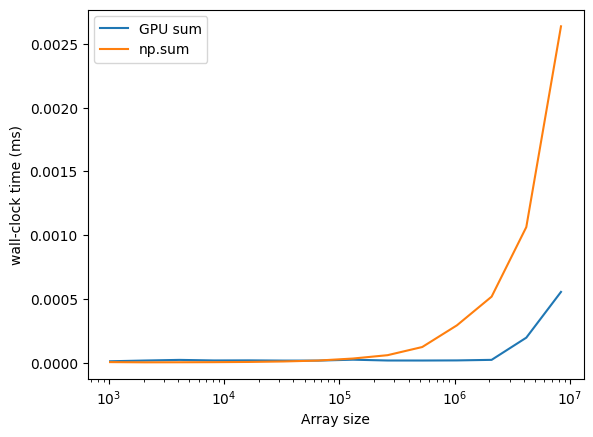

In [28]:
import matplotlib.pyplot as plt
from time import  perf_counter

mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

sizes = np.logspace(10, 23, base=2, num=14, dtype='int32')
inputs = []

for size in sizes:
    size = int(size)
    inp = cp.random.uniform(size=size).astype('float32')
    inputs.append(inp)
    
mean_times = []

for i, size in enumerate(sizes):
    size = int(size)
    times = []
    for _ in range(100):
        inp_cu = cp.copy(inputs[i])
        THREADS_PER_BLOCK = (1024, 1, 1)
        BLOCKS_PER_GRID = (roof(len(inp_cu) / THREADS_PER_BLOCK[0]), 1, 1)
        size_iter = len(inp_cu)
        duration =- perf_counter()
        while size_iter > 1:
            kernel_sequential_shared(
                BLOCKS_PER_GRID, THREADS_PER_BLOCK, 
                (
                    inp_cu, 
                    cp.int32(size_iter),
                    cp.int32(THREADS_PER_BLOCK[0]),
                ),
                shared_mem=(32//4)*THREADS_PER_BLOCK[0]
            )            
            size_iter = roof(size_iter / THREADS_PER_BLOCK[0])
        duration += perf_counter()
        times.append(duration)
    mean_times.append(np.mean(times))
plt.semilogx(sizes, mean_times, label='cuda shared mem')

vals = [] # This is to make sure numpy *does* compute results
mean_times = []
for i, size in enumerate(sizes):
    size = int(size)
    times = []
    inp = cp.asnumpy(inputs[i])
    for _ in range(100):
        duration =- perf_counter()
        vals.append(inp.sum())
        duration += perf_counter()
        times.append(duration)
    mean_times.append(np.mean(times))
    
plt.semilogx(sizes, mean_times, label='np.sum')
plt.xlabel("Array size")
plt.ylabel("wall-clock time (ms)")
plt.legend()
plt.show()